# Image classification with Swin Transformers

**Author:** [Rishit Dagli](https://twitter.com/rishit_dagli)<br>
**Date created:** 2021/09/08<br>
**Last modified:** 2021/09/08<br>
**Description:** Image classification using Swin Transformers, a general-purpose backbone for computer vision.

This example implements
[Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a
general-purpose backbone for computer vision. Swin Transformer is a hierarchical
Transformer whose representations are computed with _shifted windows_. The
shifted window scheme brings greater efficiency by limiting self-attention
computation to non-overlapping local windows while also allowing for
cross-window connections. This architecture has the flexibility to model
information at various scales and has a linear computational complexity with
respect to image size.

This example requires TensorFlow 2.5 or higher.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to
`(1, 1)`. Below, we take inspiration from the original paper settings for
training on ImageNet-1K, keeping most of the original settings for this example.

In [23]:
num_classes = 100
input_shape = (32, 32, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [22]:
from keras import backend as K
K.set_epsilon(1)

def r_sqr1(y_true, y_pred):
    # print('true:',y_true,'pred:',y_pred)
    # Use tf.reduce_sum instead of K.sum and tf.square instead of K.square
    SS_res =  tf.reduce_sum(tf.square( y_pred - tf.reduce_mean(y_true) ))
    SS_tot = tf.reduce_sum(tf.square( y_true - tf.reduce_mean(y_true) ) )
    # print('r:',(1- SS_res/SS_tot ))
    return (1-(SS_res/SS_tot) )

def mean_absolute_percentage_error(y_true, y_pred):
    # Use tf.abs, tf.clip, tf.keras.backend.epsilon, and tf.reduce_mean
    diff = tf.abs((y_true - y_pred) / tf.clip(tf.abs(y_true),
                                          tf.keras.backend.epsilon(),
                                          None))
    return 100. * tf.reduce_mean(diff, axis=-1)

def coeff(y_true, y_pred):
    # Use tf.reduce_sum instead of K.sum, tf.square instead of K.square, and tf.reduce_mean instead of K.mean
    SS_res =  tf.reduce_sum(tf.square( y_true-y_pred ))
    SS_tot = tf.reduce_sum(tf.square( y_true - tf.reduce_mean(y_true) ) )
    # Use tf.keras.backend.epsilon instead of K.epsilon
    return ( 1 - SS_res/(SS_tot + tf.keras.backend.epsilon()) )
# %%

## Prepare the data

We load the CIFAR-100 dataset through `keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

In [5]:
import tensorflow as tf

img_folder = "/content/drive/MyDrive/Final dataset/clean_images"

dataset = tf.keras.utils.image_dataset_from_directory(
    img_folder,
    labels=None,           # no labels since you only want images
    image_size=(32, 32),
    batch_size=32
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Convert to numpy array (optional)
images = np.concatenate([x.numpy() for x in dataset], axis=0)
print(images.shape)   # (5120, 256, 256, 3)

Found 5120 files.
(5120, 32, 32, 3)


In [24]:
###tabular dataset processing
#tabular dataset upload
train_data_url = (
    "/content/drive/MyDrive/Final dataset/dataset tabular/TMS_Final_Dataset_with_error.csv"
)
df = pd.read_csv(train_data_url)
#droupout unwanted columns
df = df.drop(['V1/2', 'S1/2'],axis = 1)

In [25]:
##train test splitter
train,test,train_image,test_image=train_test_split(df,images)
## normalizinng output
from sklearn.preprocessing import MinMaxScaler
cols_to_scaler=['Emax']
scaler=MinMaxScaler()
train[cols_to_scaler]=scaler.fit_transform(train[cols_to_scaler])
scaler1=MinMaxScaler()
test[cols_to_scaler]=scaler1.fit_transform(test[cols_to_scaler])
# normalizing inputs
cols_to_scaler_in=['Current(A/s)','Skin distance(mm)','WM conductivity','GM conductivity','Scalp conductivity']
scaler2=MinMaxScaler()
train[cols_to_scaler_in]=scaler2.fit_transform(train[cols_to_scaler_in])
scaler3=MinMaxScaler()
test[cols_to_scaler_in]=scaler3.fit_transform(test[cols_to_scaler_in])

## different type of input
x_train_num=train.drop(['Emax','coil type','coil position'],axis = 1)
x_train_type=train['coil type']
x_train_pos=train['coil position']
y_train=train['Emax']
x_test_num=test.drop(['Emax','coil type','coil position'],axis = 1)
x_test_type=test['coil type']
x_test_pos=test['coil position']
y_test=test['Emax']


In [26]:
###tabular
##csv file columns name
CSV_HEADER = [
    "coil type",
    "coil position",
    "Current(A/s)",
    "Skin distance(mm)",
    "WM conductivity",
    "GM conductivity",
    "Scalp conductivity",
    "V1/2",
]
### Dataset Metadata
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "Current(A/s)",
    "Skin distance(mm)",
    "WM conductivity",
    "GM conductivity",
    "Scalp conductivity",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "coil_type": sorted(list(train["coil type"].unique())),
    "coil_position": sorted(list(train["coil position"].unique()))
}

# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES  else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "V1/2"

######Configure the hyperparameters
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 16
NUM_EPOCHS = 200

NUM_TRANSFORMER_BLOCKS = 5  # Number of transformer blocks.
NUM_HEADS = 30  # Numberof attention heads.
EMBEDDING_DIMS = 5 # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    20,10
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

#### Create Model Inputs
def create_model_inputs():
    inputs = {}

    for feature_name in FEATURE_NAMES:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )

    return inputs

####Encoder features
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=1,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        # else:

        #     # Use the numerical features as-is.
        #     numerical_feature_list=inputs[feature_name]

    return encoded_categorical_feature_list

####Tabular MLP
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        # mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        # mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


In [27]:
df

,coil type,coil position,Current(A/s),Skin distance(mm),WM conductivity,GM conductivity,Scalp conductivity,Emax
0,no4,AF8,104,1.0,0.0646,0.060,0.150,204.00
1,no5,AF4,119,2.0,0.0676,0.063,0.300,276.00
2,no7,AFz,134,3.0,0.0706,0.066,0.450,319.00
3,no9,AF3,149,4.0,0.0736,0.069,0.600,326.00
4,no20,F7,164,5.0,0.0766,0.072,0.750,14.30
...,...,...,...,...,...,...,...,...
5115,no37,C4,178,14.0,0.5580,2.445,2.089,358.00
5116,no49,C6,179,15.0,0.4740,2.450,2.093,2.23
5117,no50,CP5,180,1.0,0.4760,2.455,2.097,2.00
5118,no20,C1,170,6.0,0.5420,2.405,2.057,273.00


In [8]:
##train test splitter
train,test,train_image,test_image=train_test_split(df,images)

x_train shape: (3840, 32, 32, 3) - y_train shape: (3840, 8)
x_test shape: (1280, 32, 32, 3) - y_test shape: (1280, 8)


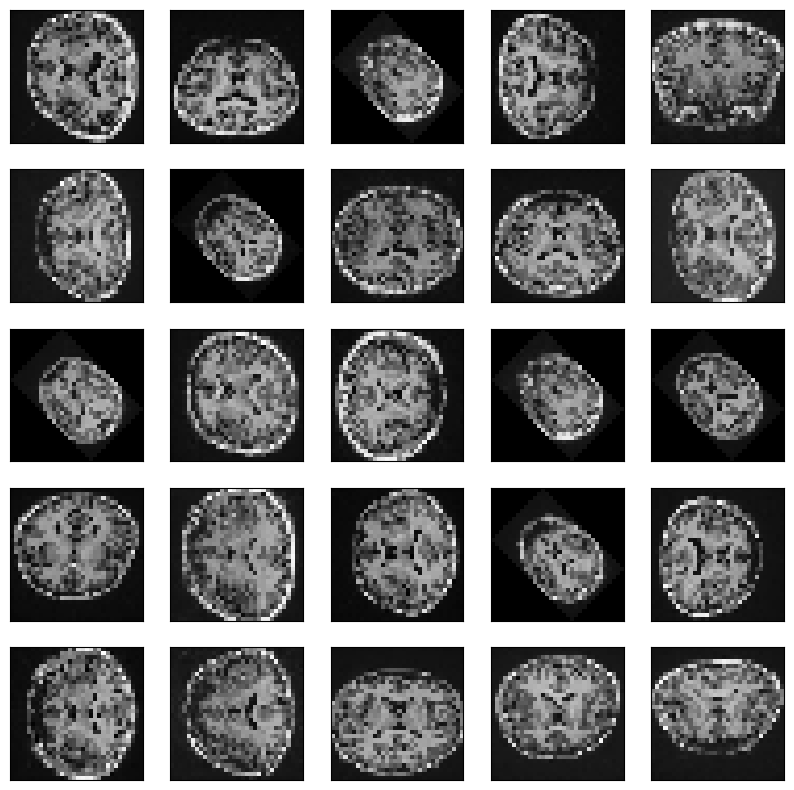

In [28]:

train_image,test_image = train_image / 255.0, test_image / 255.0
print(f"x_train shape: {train_image.shape} - y_train shape: {train.shape}")
print(f"x_test shape: {test_image.shape} - y_test shape: {test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image[i])
plt.show()


## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [29]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships
between a token and all other tokens are computed. The global computation leads
to quadratic complexity with respect to the number of tokens. Here, as the
[original paper](https://arxiv.org/abs/2103.14030) suggests, we compute
self-attention within local windows, in a non-overlapping manner. Global
self-attention leads to quadratic computational complexity in the number of
patches, whereas window-based self-attention leads to linear complexity and is
easily scalable.

In [30]:

class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard
multi-head attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [31]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [32]:

# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### Prepare the tf.data.Dataset

We do all the steps, which do not have trainable weights with tf.data.
Prepare the training, validation and testing sets.

In [16]:

def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((train_image, train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((test_image, test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((test_image, test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

### Build the model

We put together the Swin Transformer model.

In [18]:
input = layers.Input(shape=(256, 12))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(1, activation="linear", name="linear")(x)

### Train on CIFAR-100

We train the model on CIFAR-100. Here, we only train the model
for 40 epochs to keep the training time short in this example.
In practice, you should train for 150 epochs to reach convergence.

In [19]:
def coeff(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())


In [21]:
model = keras.Model(input, output)
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[coeff,'mae','mape'],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/40
14/30 ━━━━━━━━━━━━━━━━━━━━ 1:12 5s/step - coeff: -145.2285 - loss: 20362.9883 - mae: 115.5014 - mape: 1353.1837

KeyboardInterrupt: 

Let's visualize the training progress of the model.

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Let's display the final results of the training on CIFAR-100.

In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

The Swin Transformer model we just trained has just 152K parameters, and it gets
us to ~75% test top-5 accuracy within just 40 epochs without any signs of
overfitting as well as seen in above graph. This means we can train this network
for longer (perhaps with a bit more regularization) and obtain even better
performance. This performance can further be improved by additional techniques
like cosine decay learning rate schedule, other data augmentation techniques.
While experimenting, I tried training the model for 150 epochs with a slightly
higher dropout and greater embedding dimensions which pushes the performance to
~72% test accuracy on CIFAR-100 as you can see in the screenshot.

![Results of training for longer](https://i.imgur.com/9vnQesZ.png)

The authors present a top-1 accuracy of 87.3% on ImageNet. The authors also
present a number of experiments to study how input sizes, optimizers etc. affect
the final performance of this model. The authors further present using this
model for object detection, semantic segmentation and instance segmentation as
well and report competitive results for these. You are strongly advised to also
check out the [original paper](https://arxiv.org/abs/2103.14030).

This example takes inspiration from the official
[PyTorch](https://github.com/microsoft/Swin-Transformer) and
[TensorFlow](https://github.com/VcampSoldiers/Swin-Transformer-Tensorflow)
implementations.